In [2]:
import numpy as np
import matplotlib.pyplot as plt
from elements.batteryModel import LithiumIonBattery

In [3]:
udds = np.loadtxt("models/udds.txt")
udds

ik = np.hstack([np.zeros(300), udds[:,1], np.zeros(300), udds[:,1], np.zeros(241)])
t = np.arange(len(ik))/3600


Text(0, 0.5, 'Current (A)')

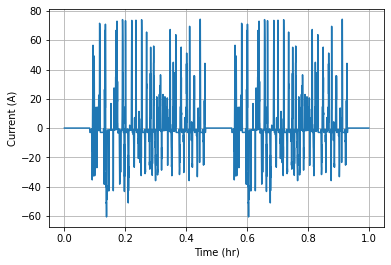

In [4]:
plt.plot(t, ik)
plt.grid()
plt.xlabel('Time (hr)')
plt.ylabel('Current (A)')


In [41]:
# battery cells
z0 = np.arange(0.9, 0.6, -0.1)       # set initial SOC for each cell in pack
R0 = np.arange(1.3, 1, -0.1)*1e-3    # set R0 for each cell in pack
Q0 = np.arange(25, 29, 1)            # set Q for each cell in pack

print(z0, R0, Q0)

cell1 = LithiumIonBattery('models/PANmodel.mat', T=25, dt=1)
cell2 = LithiumIonBattery('models/PANmodel.mat', T=25, dt=1)
cell3 = LithiumIonBattery('models/PANmodel.mat', T=25, dt=1)
cell4 = LithiumIonBattery('models/PANmodel.mat', T=25, dt=1)

cell1.z_k, cell2.z_k, cell3.z_k, cell4.z_k = z0
cell1.R0Param, cell2.R0Param, cell3.R0Param, cell4.R0Param = R0
cell1.QParam, cell2.QParam, cell3.QParam, cell4.QParam = Q0

batteryPack = [cell1, cell2, cell3, cell4]


[0.9 0.8 0.7 0.6] [0.0013 0.0012 0.0011 0.001 ] [25 26 27 28]


Text(0.5, 1.0, 'SOC versus time for 4 cells')

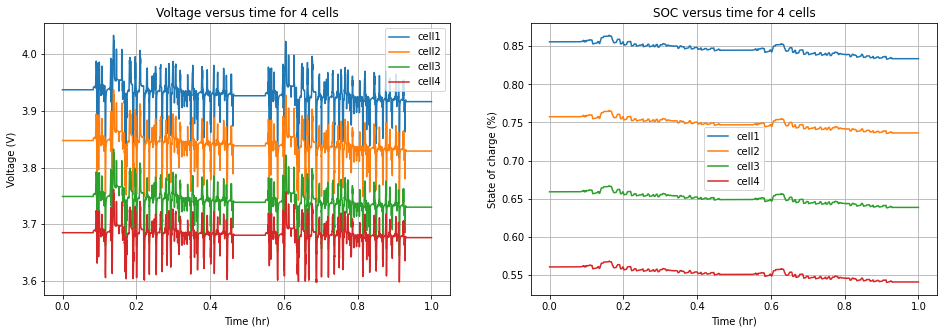

In [44]:
currents = np.zeros((len(t),len(batteryPack)))
voltages = np.zeros((len(t),len(batteryPack)))
SOCs = np.zeros((len(t),len(batteryPack)))

for k,i in enumerate(ik):
    for c,cell in enumerate(batteryPack):
        newState = cell.stateEqn(i)
        voltage = cell.outputEqn(i)
        cell.updateState(newState)

        currents[k,c] = i
        voltages[k,c] = voltage
        SOCs[k,c] = cell.z_k.ravel()


plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(t, voltages)
plt.grid()
plt.legend(['cell1','cell2','cell3','cell4'])
plt.xlabel('Time (hr)')
plt.ylabel('Voltage (V)')
plt.title('Voltage versus time for 4 cells')

plt.subplot(1,2,2)
plt.plot(t, SOCs)
plt.grid()
plt.legend(['cell1','cell2','cell3','cell4'])
plt.xlabel('Time (hr)')
plt.ylabel('State of charge (%)')
plt.title('SOC versus time for 4 cells')


In [ ]:
ibias = 0.5